# Detección de pérdidas no técnicas utilizando datos AMI

***

#### Importación de librerías de python

In [1]:

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import datetime as dt
import matplotlib.patches as mpatches

import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix
from sklearn.mixture import GaussianMixture
from sklearn import metrics

import random
import seaborn as sns
import warnings

from tsfresh import extract_features
from tsfresh.feature_selection.relevance import calculate_relevance_table
from tsfresh.feature_selection.selection import select_features

import holidays
pd.options.display.max_columns = 20

#warnings.filterwarnings("ignore", 
#message="The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.")

## 1. Lectura de los de datos

In [1]:
def leer_datos(estrato):
    """
    Función que recupera los datos de los clientes por estrato
    Es necesario utilizar chunks por el tamaño de los archivos
    """
    filename = "C:\\Users\\Juan Gerónimo\\OneDrive - correounivalle.edu.co\\Tesis\\AMI_DATA\\DataSet_AMI.csv"
    chunksize = 10 ** 6
    chunks = pd.read_csv(filename, sep=',', chunksize=chunksize, header = 0, parse_dates=['FECHA'])
    df = pd.concat([chunk[chunk['cod_estrato'] == 'R' + str(estrato) + '4'] for chunk in chunks])
    df.to_csv("C:\\Users\\Juan Gerónimo\\OneDrive - correounivalle.edu.co\\Tesis\\AMI_DATA\\df_estrato_" + str(estrato) + ".csv", index=False)
    print("exportación exitosa")

In [37]:
%%time
df_preprocessed = pd.read_csv("C:\\Users\\Juan Gerónimo\\OneDrive - correounivalle.edu.co\\Tesis\\AMI_DATA\\df_estrato_3.csv", sep=',',
                          header = 0, parse_dates=['FECHA'], dtype = {'COD_PUNTO_MEDIDA':'object', 'Estrato':'category'})#, skiprows = 20000000, nrows = 40000000)

Wall time: 56min 40s


Total medidores estrato 1 = 3010
Total medidores estrato 2 = 19004 y quedaron 16596
11 millones de registros
Para el estrato 1
0    1819
1     221

Para el estrato 2

In [38]:
def preprocesamiento(df_balanced):
    
    # Se remueven datos duplicados
    df_balanced = df_balanced[~df_balanced.duplicated()]
    
    # Medidores con datos mayores a 90 días
    medidores = df_balanced.COD_MEDIDOR.value_counts()
    medidores = medidores.index[medidores > 2160].to_list()
    df_balanced = df_balanced[df_balanced.COD_MEDIDOR.isin(medidores)]
    
    # Se crean columnas
    df_balanced = df_balanced.assign(Hora = df_balanced.FECHA.dt.hour)
    df_balanced = df_balanced.assign(dia = df_balanced.FECHA.dt.day) 
    
    # Se garantizan datos por hora > 89 días 
    data_per_hour = df_balanced.groupby(['COD_MEDIDOR','Hora']).size().reset_index()
    data_per_hour.columns = ['COD_MEDIDOR', 'Hora', 'Consumos']
    data_per_hour = data_per_hour.pivot(index = "COD_MEDIDOR",columns = "Hora", values = "Consumos")
    data_per_hour = data_per_hour.sort_values(by=23)
    data_per_hour_90 = data_per_hour[(data_per_hour > 89).all(axis=1)].index.to_list()

    # Se garantizan datos por día > 47 horas
    data_per_day = df_balanced.groupby(['COD_MEDIDOR','dia']).size().reset_index()
    data_per_day.columns = ['COD_MEDIDOR', 'dia', 'Consumos']
    data_per_day = data_per_day.pivot(index = "COD_MEDIDOR",columns = "dia", values = "Consumos")
    data_per_day = data_per_day.sort_values(by=23)
    data_per_day_48 = data_per_day[(data_per_day > 47).all(axis=1)].index.to_list()
    
    # Se filtran los medidores que cumplen con el mínimo de datos
    df = df_balanced[(df_balanced.COD_MEDIDOR.isin(data_per_hour_90)) & (df_balanced.COD_MEDIDOR.isin(data_per_day_48))]
    df = df.reset_index(drop = True)
    return df

## 2. Pre-Procesamiento
### 2.1 Preparación de los datos para el cálculo del consumo promedio horario

In [39]:
def calculo_consumos_horarios(df):
    Hour = df[['FECHA','COD_MEDIDOR', 'CONSUMO']]
    Hour = Hour.assign(Hora=lambda x: Hour['FECHA'].dt.hour)
    Horario = Hour.groupby(['COD_MEDIDOR','Hora'], as_index=False).mean()
    Horario = Horario.pivot(index='COD_MEDIDOR', columns = 'Hora', values= 'CONSUMO')
    Horario = Horario.loc[~(Horario==0).all(axis=1)]
    Horario = Horario.dropna()
    return Horario

### 2.2 Detección y eliminación de outliers (datos atípicos)

In [40]:
def detect_outlier(fila):
    """ Esta función se utiliza para detectar curvas promedio atípicas donde se tiene que una hora del día supera 4.5 veces
        el promedio del resto de las horas del día (158)
    """
    max_value = fila.max()
    hora_max = fila.idxmax()
    horas_dif = fila[fila.index != fila.idxmax()]
    promedio_dif = horas_dif.mean()
    
    if promedio_dif == 0:
        label = True    
    elif max_value/promedio_dif > 3.5 :
        label = True
    else:
        label = False
    return label

In [2]:
def drop_outliers(Horario):
    """
    Función utilizada para detectar y remover los datos atípicos de consumo
    """
    outliers_series = Horario.apply(detect_outlier, axis = "columns")
    outliers = Horario[outliers_series]
    X_hours = Horario.drop(index=outliers.index)
    return X_hours, outliers

## 3. Análisis exploratorio de los datos

<div class="alert alert-block alert-success">
<b>EDA:</b> Se deben colocar gráficas descriptivas de las tres features, histogram or violin to load shapes and for stasticial parameters
</div>

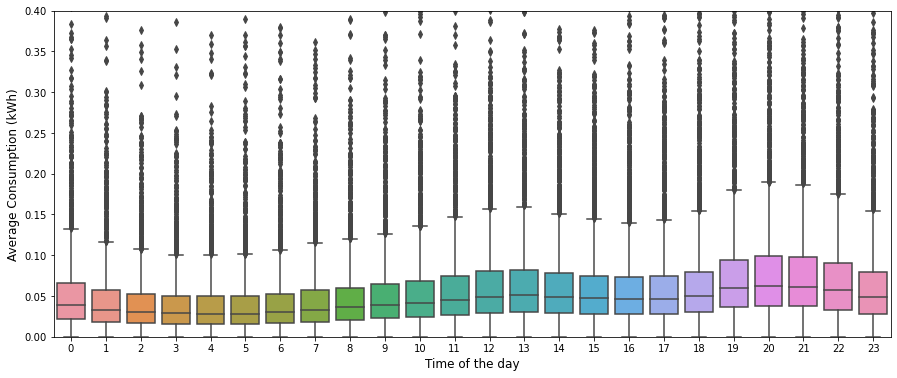

In [215]:
fig, ax = plt.subplots(figsize=(15,6))
ax = sns.boxplot(data=X_hours, saturation = 0.75);
# ax.set_title('Box plots for each hour of')
ax.set_ylabel('Average Consumption (kWh)', fontsize = 12);
ax.set_xlabel('Time of the day', fontsize = 12);
plt.ylim(0,0.4);
#plt.savefig(r"C:\Users\Juan Gerónimo\OneDrive - correounivalle.edu.co\Tesis\Plots\box_plot.png", dpi=600)
# Una curva por cada estrato box_plot caja más compacta y menos puntos fuera de las bigotes

(0.0, 1.0)

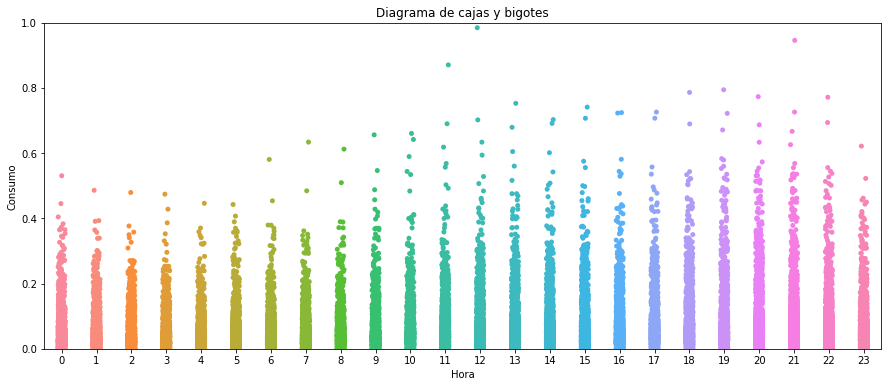

In [216]:
fig, ax = plt.subplots(figsize=(15,6))
ax = sns.stripplot(data=X_hours);
ax.set_title('Diagrama de cajas y bigotes')
ax.set_ylabel('Consumo');
plt.ylim(0,1)
# plt.savefig('G:/Mi unidad/Maestria_Univalle/Semestre_4/Investigacion/strip_plot_out3.png', dpi=600)

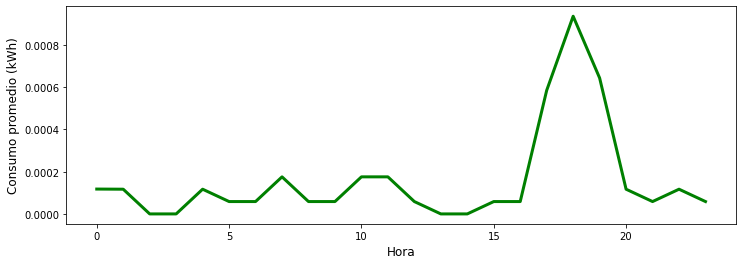

In [262]:
fig, axs = plt.subplots(figsize=(12, 4))
#plt.title('Load profile for detected outliers', fontsize = 12)
# plt.plot(outliers.columns, outliers.iloc[40], color='orange', alpha=1, linewidth='3')
# plt.plot(outliers.columns, outliers.iloc[29], color='blue', alpha=1, linewidth='3')
plt.plot(outliers.columns, outliers.iloc[12], color='green', alpha=1, linewidth='3')
plt.xlabel('Hora', fontsize = 12)
plt.ylabel('Consumo promedio (kWh)',  fontsize = 12)
#plt.legend(['Outlier 1', 'Outlier 2', 'Outlier 3'], loc='upper left')
# plt.savefig(r"C:\Users\Juan Gerónimo\OneDrive - correounivalle.edu.co\Tesis\Plots\atipico3.png", dpi=600)
# plt.ylim(0, 1)
plt.show()

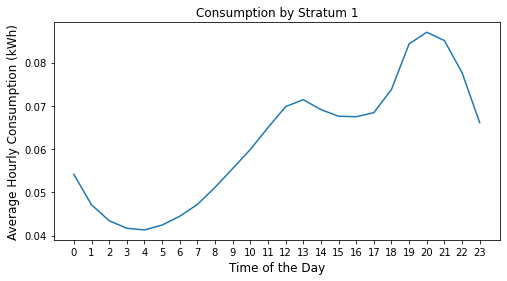

In [230]:
fig, axs = plt.subplots(figsize=(8, 4))
plt.title('Consumption by Stratum 1', fontsize = 12)
plt.plot(data_set.columns[:24],data_set.iloc[:,:24].mean())

plt.xlabel('Time of the Day', fontsize = 12)
plt.xticks(range(24))
plt.ylabel('Average Hourly Consumption (kWh)', fontsize = 12);
#plt.savefig(r"C:\Users\Juan Gerónimo\OneDrive - correounivalle.edu.co\Tesis\Plots\Consumption_stratum.png", dpi=600)

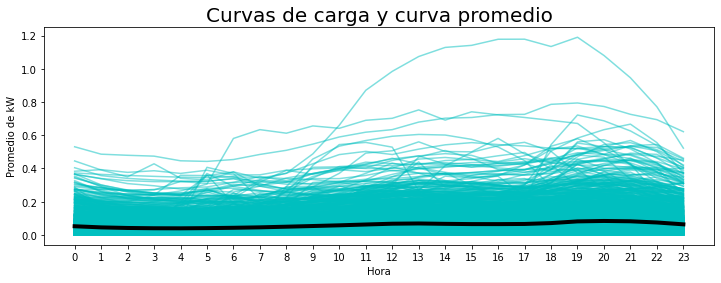

In [232]:
fig, axs = plt.subplots(figsize=(12, 4))
plt.title('Curvas de carga y curva promedio', fontsize = 20)
for y in range(len(X_hours)):
    axs.plot(X_hours.columns,
            X_hours.iloc[y],
            color='c',
            alpha=.5)
# plt.plot(Horario, color='c', alpha=0.1, linewidth='3')
plt.plot(Horario.columns,Horario.mean(),color='k', alpha=1, linewidth='4')
plt.xlabel('Hora')
plt.xticks(range(24))
plt.ylabel('Promedio de kW')
# plt.ylim(0.075, 1)
plt.show()

In [199]:
plot_df = df_preprocessed[["FECHA","COD_MEDIDOR","CONSUMO"]]
pivot_df = plot_df.pivot(index = "COD_MEDIDOR",columns = "FECHA", values = "CONSUMO")
pivot_df = pivot_df.reset_index(drop=True)

In [200]:
xlabels = []
dates = plot_df["FECHA"].drop_duplicates().sort_values().dt.strftime('%Y-%m-%d %H').reset_index(drop=True)
for i in range(0,len(dates),int(len(dates)/54)):
    xlabels.append(dates[i])

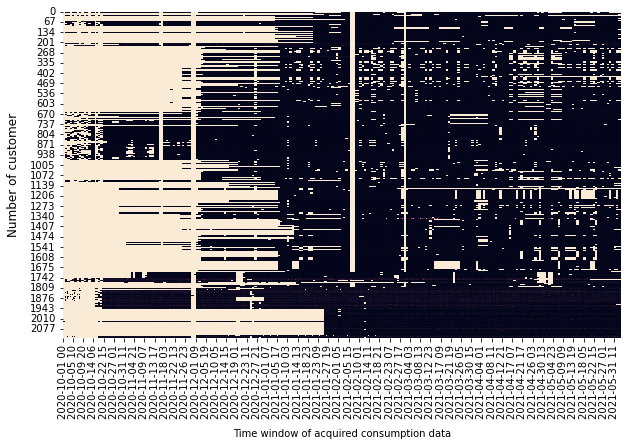

In [201]:
plt.figure(figsize=(10, 6))
ax = sns.heatmap(pivot_df, cbar=False);

ax.set_xticklabels(xlabels)
ax.set_facecolor("antiquewhite")
# plt.title('Heatmap of Flighr Dataset', fontsize = 20)
plt.xlabel('Time window of acquired consumption data', labelpad=10) # x-axis label with fontsize 15
plt.ylabel('Number of customer', fontsize = 12, labelpad=10) # y-axis label with fontsize 15
plt.savefig(r"C:\Users\Juan Gerónimo\OneDrive - correounivalle.edu.co\Tesis\Plots\MissingValues_stra1_processed.png", 
            dpi=600, 
            bbox_inches='tight')
plt.show()

## 4. Selección de características

#### Características de la curva de carga

In [42]:
def calc_load_shape(X_hours):

    X_load_shape = pd.DataFrame()

    X_load_shape['Max_Hora'] = X_hours.idxmax(axis=1)
    X_load_shape['Factor_Carga'] = X_hours.mean(axis=1)/X_hours.max(axis=1)
    X_load_shape['Tasa_Uso_Min'] = X_hours.min(axis=1)/X_hours.max(axis=1)
    X_load_shape['peak-valley'] = (X_hours.max(axis=1)-X_hours.min(axis=1))/X_hours.max(axis=1)
    X_load_shape['peak_Load_Factor'] = X_hours.iloc[:,[11,12,13,18,19,20,21,22]].mean(axis=1)/X_hours.mean(axis=1)
    X_load_shape['flat_Load_Factor'] = X_hours.iloc[:,[7,8,9,10,14,15,16,17]].mean(axis=1)/X_hours.mean(axis=1)
    X_load_shape['valley_Load_Factor'] = X_hours.iloc[:,[23,0,1,2,3,4,5,6]].mean(axis=1)/X_hours.mean(axis=1)
    return X_load_shape

#### Características por día de la semana (se utiliza librería holidays de python)

In [43]:
co_holidays = holidays.CO()
def is_holiday(fecha):
    """ Esta función se utiliza para descriminar los día de la semana entre lunes a domingo y festivos 
        utilizando la librería holidays python-holidays
    """
    
    if (fecha.date() in co_holidays):
        label = 'Holiday'    
    else:
        label = fecha.day_name()
    return label

In [44]:
def calc_weekdays(df_preprocessed, X_hours):
    df = df_preprocessed[df_preprocessed['COD_MEDIDOR'].isin(X_hours.index)]
    timeseries = df.drop(columns=['cod_estrato','Hora','dia']).reset_index(drop = True)
        
    timeseries['Weekday'] = timeseries['FECHA'].apply(is_holiday)
    Weekdays = timeseries.groupby(['COD_MEDIDOR','Weekday'], as_index=False).mean()
    X_weekdays = Weekdays.pivot(index='COD_MEDIDOR', columns = 'Weekday', values= 'CONSUMO')

    column_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Holiday']
    X_weekdays = X_weekdays.reindex(columns=column_order)

    return X_weekdays

#### Se obtienen características estadísticas directamente de la curva de carga

In [45]:
def calc_statistics(X_hours):
    X_statistics = pd.DataFrame()
    X_statistics['Mean'] = X_hours.mean(axis=1)
    X_statistics['Median'] = X_hours.median(axis=1)
    X_statistics['Maximum'] = X_hours.max(axis=1)
    X_statistics['Minimum'] = X_hours.min(axis=1)
    X_statistics['Standard_Dev'] = X_hours.std(axis=1)
    return X_statistics

In [46]:
""" Esta celda corre el pipeline para el cálculo de características de los datos de consumo """
df_preprocessed = preprocesamiento(df_preprocessed)
Horario = calculo_consumos_horarios(df_preprocessed)
X_hours, outliers = drop_outliers(Horario)
X_load_shape = calc_load_shape(X_hours)
X_weekdays = calc_weekdays(df_preprocessed, X_hours)
X_statistics = calc_statistics(X_hours)

In [47]:
feats = pd.concat([X_hours, X_load_shape, X_weekdays, X_statistics], axis=1).reindex(X_hours.index)
feats.columns = feats.columns.astype('string')
feats.to_csv("C:\\Users\\Juan Gerónimo\\OneDrive - correounivalle.edu.co\\Tesis\\AMI_DATA\\feats_stratum_3.csv", index=False)

#### Se obtienen características estadísticas de la serie de tiempo completa

In [23]:
fc_parameters = {
     "mean": None,
     "median": None,
     "maximum": None,
     "minimum": None,
#     "kurtosis": None,
#     "skewness": None,
    "standard_deviation": None,
#     "variance": None,
#     "variation_coefficient":None,
#     "number_peaks":[{"n":8}],
#     "count_above_mean": None,
#     "longest_strike_above_mean": None,
#     "longest_strike_below_mean": None,
#     "mean_change": None,
#     "mean_n_absolute_max": [{"number_of_maxima":120}],
#     "number_cwt_peaks": [{"n":24}]
    }

In [24]:
extracted_features = extract_features(timeseries.iloc[:,:3], default_fc_parameters = fc_parameters, column_id="COD_MEDIDOR", column_sort="FECHA")
X_statistics2 = extracted_features

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.03s/it]


## 5. Técnica de Machine Learning: Clustering K-Means y Gaussian Mixture Model

### Escalamiento de los datos

In [74]:
# scaler = MinMaxScaler()
scaler = StandardScaler()
feats_scl = scaler.fit_transform(feats)
feats_scl = pd.DataFrame(feats_scl, index = feats.index,columns = feats.columns)

### Evaluación de la correlación de las características

In [52]:
dfs = [feats_scl.iloc[:,:24], feats_scl.iloc[:,24:31], feats_scl.iloc[:,31:39], feats_scl.iloc[:,39:44]]

In [ ]:
X = feats_scl.copy()
df_clusters = pd.DataFrame(columns = ['cluster_number_km', 'cluster_number_gmm'])
results = pd.DataFrame(columns = ['Sil_km', 'Desv_km', 'Sil_gmm', 'Desv_gmm'])
for k in range(2,15):
    km = KMeans(n_clusters = k, random_state=0)
    gmm = GaussianMixture(n_components = k, covariance_type = 'spherical', random_state=0)
    
    df_clusters['cluster_number_km'] = km.fit_predict(X)
    df_clusters['cluster_number_gmm'] = gmm.fit_predict(X)
    
    sil_km = metrics.silhouette_score(X, df_clusters['cluster_number_km'], metric="euclidean", sample_size=None)
    sil_gmm = metrics.silhouette_score(X, df_clusters['cluster_number_gmm'], metric="euclidean", sample_size=None)
    
    desv_km = df_clusters['cluster_number_km'].value_counts().std()
    desv_gmm = df_clusters['cluster_number_gmm'].value_counts().std()
    
    R = pd.DataFrame({'Sil_km': sil_km, 'Desv_km': desv_km, 'Sil_gmm': sil_gmm, 'Desv_gmm': desv_gmm}, index = [k])
    results = pd.concat([results, R])

In [76]:
results

,Sil_km,Desv_km,Sil_gmm,Desv_gmm
2,0.43683,7656.552227,0.396933,5256.631811
3,0.37331,6384.792035,0.305721,4068.092223
4,0.318212,5101.701252,0.228163,2946.504879
5,0.277886,4383.455771,0.198818,2362.830506
6,0.230425,2947.595201,0.172844,1134.957738
7,0.219715,2442.630335,0.164184,860.088727
8,0.226527,2259.365888,0.160313,890.344195
9,0.217149,2020.58305,0.150642,893.182154
10,0.216711,1839.090234,0.14752,807.348197
11,0.216788,1749.607977,0.12859,767.293863


In [79]:
km = KMeans(n_clusters = 2)
gmm = GaussianMixture(n_components=2, covariance_type = 'spherical',random_state=0)
df_clusters = pd.DataFrame(index = feats_scl.index , columns = ['cluster_number_km', 'cluster_number_gmm'])
results = pd.DataFrame(columns = ['Sil_km', 'Desv_km', 'Sil_gmm', 'Desv_gmm'])
for i in range(24,45):
    
    # Adding a new column 'cluster_number' containing cluster assignment (0 to 4) for each household.
    F = feats_scl.copy()
    F = F.iloc[:,:i]
    
    df_clusters['cluster_number_km'] = km.fit_predict(F)
    df_clusters['cluster_number_gmm'] = gmm.fit_predict(F)
    
    sil_km = metrics.silhouette_score(F, df_clusters['cluster_number_km'], metric="euclidean", sample_size=None)
    desv_km = df_clusters['cluster_number_km'].value_counts().std()
    
    sil_gmm = metrics.silhouette_score(F, df_clusters['cluster_number_gmm'], metric="euclidean", sample_size=None)
    desv_gmm = df_clusters['cluster_number_gmm'].value_counts().std()
    
    R = pd.DataFrame({'Sil_km': sil_km, 'Desv_km': desv_km, 'Sil_gmm': sil_gmm, 'Desv_gmm': desv_gmm}, index = [i])
    results = pd.concat([results, R])

In [80]:
results

,Sil_km,Desv_km,Sil_gmm,Desv_gmm
24,0.524983,7670.694362,0.42607,1306.733332
25,0.497737,7674.937003,0.413992,951.765727
26,0.472721,7632.510596,0.421712,3645.842564
27,0.45306,7554.72885,0.419835,5122.281523
28,0.438095,7568.870986,0.408743,5569.173009
29,0.423624,7584.427335,0.395839,5894.442128
30,0.410914,7585.841549,0.371194,5594.628853
31,0.400103,7605.640538,0.352948,5430.58008
32,0.405534,7707.463915,0.358727,5447.550642
33,0.407943,7598.569471,0.364513,5460.278564


### Feature Selection
Con los resultados obtenidos se realimenta el modelo para detectar la importancia de cada variable
(librería tsfresh de python)

In [ ]:
df_clusters = df_clusters.astype('category')
relevance_table = calculate_relevance_table(feats_scl, df_clusters['cluster_number_km'], ml_task = 'classification', multiclass = False)
feats_rel = feats_scl.loc[:,relevance_table.index[relevance_table.relevant==True]]

In [ ]:
km = KMeans(n_clusters = 2)
gmm = GaussianMixture(n_components=2, covariance_type = 'spherical',random_state=0)
df_clusters = pd.DataFrame(index = feats_rel.index , columns = ['cluster_number_km', 'cluster_number_gmm'])
results = pd.DataFrame(columns = ['Sil_km', 'Desv_km', 'Sil_gmm', 'Desv_gmm'])
for i in range(24,45):
    
    # Adding a new column 'cluster_number' containing cluster assignment (0 to 4) for each household.
    F = feats_rel.copy()
    F = F.iloc[:,:i]
    
    df_clusters['cluster_number_km'] = km.fit_predict(F)
    df_clusters['cluster_number_gmm'] = gmm.fit_predict(F)
    
    sil_km = metrics.silhouette_score(F, df_clusters['cluster_number_km'], metric="euclidean", sample_size=None)
    desv_km = df_clusters['cluster_number_km'].value_counts().std()
    
    sil_gmm = metrics.silhouette_score(F, df_clusters['cluster_number_gmm'], metric="euclidean", sample_size=None)
    desv_gmm = df_clusters['cluster_number_gmm'].value_counts().std()
    
    R = pd.DataFrame({'Sil_km': sil_km, 'Desv_km': desv_km, 'Sil_gmm': sil_gmm, 'Desv_gmm': desv_gmm}, index = [i])
    results = pd.concat([results, R])

#### Modelo final entrenado con las características seleccionadas

In [87]:
#feats_final = feats_rel.copy()
feats_final = feats_scl.copy()
km = KMeans(n_clusters = 2, random_state = 0)
# Adding a new column 'cluster_number' containing cluster assignment (0 to 4) for each household.

feats_scl['cluster_number']=km.fit_predict(feats_final)
df_final = feats_scl.copy()

# The silhouette score requires the full dataset
results = metrics.silhouette_score(df_final.iloc[:,:24], df_final['cluster_number'], metric="euclidean", sample_size=None)
sdv = df_final['cluster_number'].value_counts().std()
print('La métrica de Silhoutte Scores es {:.2f}\nLa desviación estándar es: {:.2f}'.format(results, sdv))

La métrica de Silhoutte Scores es 0.52
La desviación estándar es: 7656.55


## 6 Evaluación de los algoritmos de ML

### 6.1 Gráfica de usuario atípico detectado

In [242]:
suspects = x_0[~x_0.idxmax(axis=1).isin([18,19,20,21,22])]

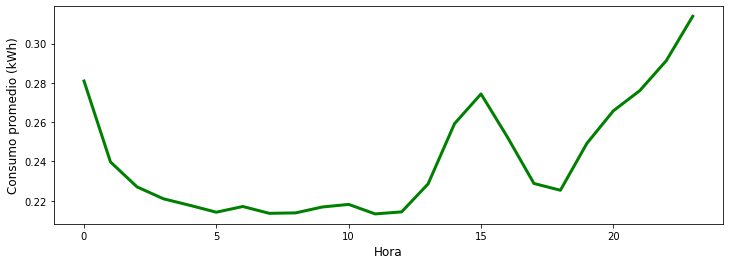

In [267]:
fig, axs = plt.subplots(figsize=(12, 4))
#plt.title('Load profile for detected outliers', fontsize = 12)
# plt.plot(outliers.columns, outliers.iloc[40], color='orange', alpha=1, linewidth='3')
# plt.plot(outliers.columns, outliers.iloc[29], color='blue', alpha=1, linewidth='3')
plt.plot(suspects.columns, suspects.iloc[10], color='green', alpha=1, linewidth='3')
"iloc interesantes: 2, 4,40, 10, 11 "
plt.xlabel('Hora', fontsize = 12)
plt.ylabel('Consumo promedio (kWh)',  fontsize = 12)
#plt.legend(['Outlier 1', 'Outlier 2', 'Outlier 3'], loc='upper left')
# plt.savefig(r"C:\Users\Juan Gerónimo\OneDrive - correounivalle.edu.co\Tesis\Plots\atipico3.png", dpi=600)
# plt.ylim(0, 1)
plt.show()

### 6.1 Gráfica de clusters y desviación estándar de cada uno

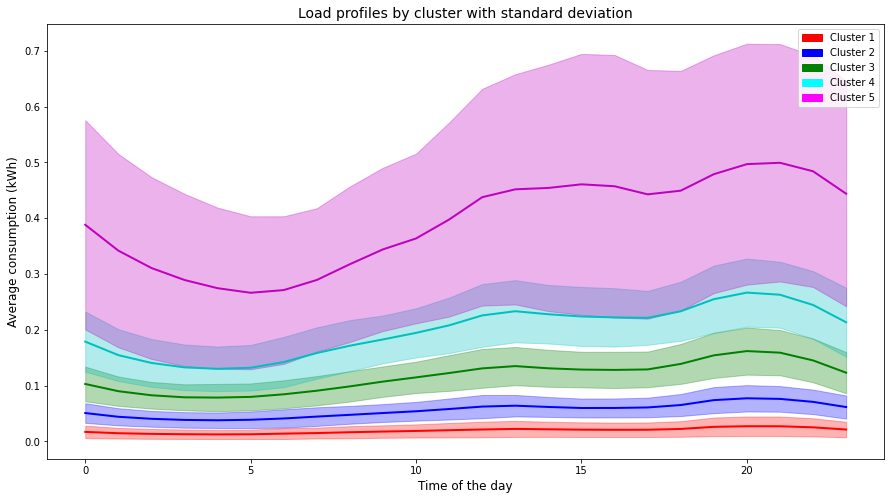

In [40]:
plt.figure(figsize=(15,8))
plt.xlabel('Time of the day', fontsize = 12)
plt.ylabel('Average consumption (kWh)', fontsize = 12)
plt.title('Load profiles by cluster with standard deviation', fontsize = 14)

x_0_mas_sigma = (x_0).mean() + (x_0).std()
x_0_menos_sigma = (x_0).mean() - (x_0).std()
plt.plot((x_0).mean(), color='r', linewidth = 2)
plt.fill_between(x_0.columns.astype('float64'),x_0_mas_sigma, x_0_menos_sigma,color = 'r', alpha = 0.3)

x_1_mas_sigma = (x_1).mean() + (x_1).std()
x_1_menos_sigma = (x_1).mean() - (x_1).std()
plt.plot((x_1).mean(), color='b', linewidth = 2)
plt.fill_between(x_1.columns.astype('float64'),x_1_mas_sigma, x_1_menos_sigma,color = 'b', alpha = 0.3)

x_2_mas_sigma = (x_2).mean() + (x_2).std()
x_2_menos_sigma = (x_2).mean() - (x_2).std()
plt.plot((x_2).mean(), color='g', linewidth = 2)
plt.fill_between(x_2.columns.astype('float64'),x_2_mas_sigma, x_2_menos_sigma,color = 'g', alpha = 0.3)

x_3_mas_sigma = (x_3).mean() + (x_3).std()
x_3_menos_sigma = (x_3).mean() - (x_3).std()
plt.plot((x_3).mean(), color='c', linewidth = 2)
plt.fill_between(x_3.columns.astype('float64'),x_3_mas_sigma, x_3_menos_sigma,color = 'c', alpha = 0.3)

x_4_mas_sigma = (x_4).mean() + (x_4).std()
x_4_menos_sigma = (x_4).mean() - (x_4).std()
plt.plot((x_4).mean(), color='m', linewidth = 2)
plt.fill_between(x_4.columns.astype('float64'),x_4_mas_sigma, x_4_menos_sigma,color = 'm', alpha = 0.3)


c = mpatches.Patch(color='red', label='Cluster 1')
d = mpatches.Patch(color='blue', label='Cluster 2')
e = mpatches.Patch(color='green', label='Cluster 3')
f = mpatches.Patch(color='cyan', label='Cluster 4')
g = mpatches.Patch(color='magenta', label='Cluster 5')

plt.legend(handles=[c,d,e,f,g])

#plt.savefig(r"C:\Users\Juan Gerónimo\OneDrive - correounivalle.edu.co\Tesis\Plots\Consumptions_Cluster_std.png", dpi=600)
plt.show()

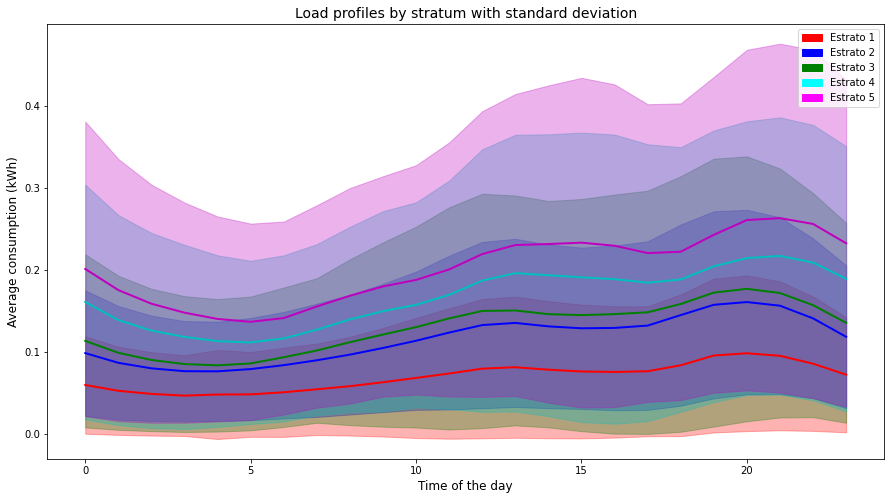

In [41]:
x_0 = data_set.iloc[:,:24].loc[(data_set['Estrato']=='1')].reset_index(drop=True)
x_1 = data_set.iloc[:,:24].loc[(data_set['Estrato']=='2')].reset_index(drop=True)
x_2 = data_set.iloc[:,:24].loc[(data_set['Estrato']=='3')].reset_index(drop=True)
x_3 = data_set.iloc[:,:24].loc[(data_set['Estrato']=='4')].reset_index(drop=True)
x_4 = data_set.iloc[:,:24].loc[(data_set['Estrato']=='5')].reset_index(drop=True)

plt.figure(figsize=(15,8))
plt.xlabel('Time of the day', fontsize = 12)
plt.ylabel('Average consumption (kWh)', fontsize = 12)
plt.title('Load profiles by stratum with standard deviation', fontsize = 14)

x_0_mas_sigma = (x_0).mean() + (x_0).std()
x_0_menos_sigma = (x_0).mean() - (x_0).std()
plt.plot((x_0).mean(), color='r', linewidth = 2)
plt.fill_between(x_0.columns.astype('float64'),x_0_mas_sigma, x_0_menos_sigma,color = 'r', alpha = 0.3)

x_1_mas_sigma = (x_1).mean() + (x_1).std()
x_1_menos_sigma = (x_1).mean() - (x_1).std()
plt.plot((x_1).mean(), color='b', linewidth = 2)
plt.fill_between(x_1.columns.astype('float64'),x_1_mas_sigma, x_1_menos_sigma,color = 'b', alpha = 0.3)

x_2_mas_sigma = (x_2).mean() + (x_2).std()
x_2_menos_sigma = (x_2).mean() - (x_2).std()
plt.plot((x_2).mean(), color='g', linewidth = 2)
plt.fill_between(x_2.columns.astype('float64'),x_2_mas_sigma, x_2_menos_sigma,color = 'g', alpha = 0.3)

x_3_mas_sigma = (x_3).mean() + (x_3).std()
x_3_menos_sigma = (x_3).mean() - (x_3).std()
plt.plot((x_3).mean(), color='c', linewidth = 2)
plt.fill_between(x_3.columns.astype('float64'),x_3_mas_sigma, x_3_menos_sigma,color = 'c', alpha = 0.3)

x_4_mas_sigma = (x_4).mean() + (x_4).std()
x_4_menos_sigma = (x_4).mean() - (x_4).std()
plt.plot((x_4).mean(), color='m', linewidth = 2)
plt.fill_between(x_4.columns.astype('float64'),x_4_mas_sigma, x_4_menos_sigma,color = 'm', alpha = 0.3)


c = mpatches.Patch(color='red', label='Estrato 1')
d = mpatches.Patch(color='blue', label='Estrato 2')
e = mpatches.Patch(color='green', label='Estrato 3')
f = mpatches.Patch(color='cyan', label='Estrato 4')
g = mpatches.Patch(color='magenta', label='Estrato 5')

plt.legend(handles=[c,d,e,f,g])

#plt.savefig(r"C:\Users\Juan Gerónimo\OneDrive - correounivalle.edu.co\Tesis\Plots\Consumptions_Stratum_std.png", dpi=600)
plt.show()

### 6.2 Visualización de Clusters y métrica de silueta

In [ ]:
# The silhouette score requires the full dataset
results = metrics.silhouette_score(feats_final.iloc[:,:36], feats_final['cluster_number']
                                   , metric="euclidean", sample_size=None)
print('La métrica de Silhoutte Scores es {:.2f}\n'.format(results))

reduced_data = PCA(n_components=2).fit_transform(feats_final.iloc[:,:36])

plt.figure(figsize=(10,8))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=consumptions['Cluster'], palette='deep')
plt.title('Clusters')
plt.legend(title = "Número de cluster")
#plt.savefig(r"C:\Users\Juan Gerónimo\OneDrive - correounivalle.edu.co\Tesis\Plots\PCA.png", dpi=600)
plt.show()

### 6.3 Matriz de confusión

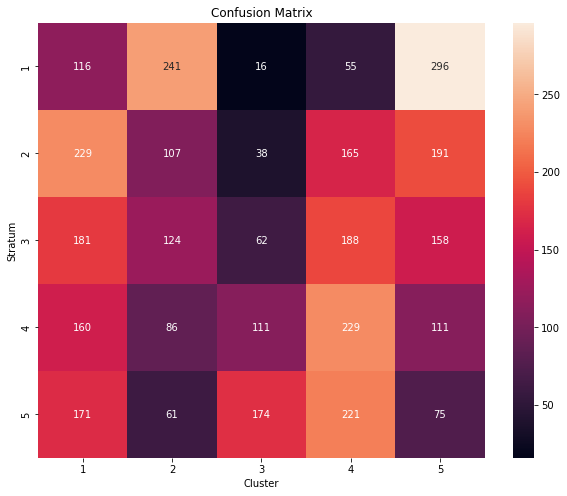

In [38]:
cm = confusion_matrix(df_final['Estrato'], df_final['cluster_number']) # should be the same dtype
cm_df = pd.DataFrame(cm, index = [1,2,3,4,5],
                    columns = [1,2,3,4,5])

plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Stratum')
plt.xlabel('Cluster')
#plt.savefig(r"C:\Users\Juan Gerónimo\OneDrive - correounivalle.edu.co\Tesis\Plots\ConfusionMatrix.png", dpi=600)
plt.show()